# YLE modelling script

20-02-24

Katie Willis 

Katie.willis@imperial.ac.uk

___

This file contains code required to generate all figures and values associated with the publication.



## Setup

In [1]:
] activate ./Environment

  Activating project at `~/Library/CloudStorage/OneDrive-ImperialCollegeLondon/PhD work/Drive_modelling/Projects/YLE_Ignacio/GithubCode/Environment`


In [2]:
] status

Status `~/Library/CloudStorage/OneDrive-ImperialCollegeLondon/PhD work/Drive_modelling/Projects/YLE_Ignacio/GithubCode/Environment/Project.toml`
⌃ [336ed68f] CSV v0.10.12
  [a93c6f00] DataFrames v1.6.1
  [8bb1440f] DelimitedFiles v1.9.1
  [31c24e10] Distributions v0.25.109
  [e850a1a4] GpABC v0.1.1
⌃ [033835bb] JLD2 v0.4.45
⌃ [0db19996] NBInclude v2.3.0
⌃ [91a5bcdd] Plots v1.39.0
⌃ [d330b81b] PyPlot v2.11.2
⌃ [24249f21] SymPy v2.0.1
  [8ba89e20] Distributed
  [37e2e46d] LinearAlgebra
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [3]:
using NBInclude
@nbinclude("./Environment/Setup.ipynb");
@nbinclude("./YLEModel.ipynb");

## Define variables

In [4]:
#Define all alleles and genotypes 

A_alleles = ["A","a","α"];
#A = target site
#a = edit 1
#α = edit 2

Y_genotypes = ["Y","y"];
#Y = WT
#y = construct

#Define all allele and genotypes in females
falleles = A_alleles
genotypes_f = []
for i in 1:length(falleles)
    allele1 = falleles[i]
    for j in i:length(falleles)
        allele2 = falleles[j]
        push!(genotypes_f,([allele1 allele2]))
    end
end;
        
#Define all allele combos and genotypes in males
#For males there are two options for Y, therefore double the number of alleles and genotypes
malleles = []
for A in A_alleles
    for Y in Y_genotypes
        push!(malleles,(A, Y))
    end
end
genotypes_m = []
for i in genotypes_f
    allele1 = i[1]
    allele2 = i[2]
    for yallele in Y_genotypes
        push!(genotypes_m,([allele1 allele2 yallele]))
    end
end

In [5]:
genotypes_f

6-element Vector{Any}:
 ["A" "A"]
 ["A" "a"]
 ["A" "α"]
 ["a" "a"]
 ["a" "α"]
 ["α" "α"]

In [6]:
genotypes_m

12-element Vector{Any}:
 ["A" "A" "Y"]
 ["A" "A" "y"]
 ["A" "a" "Y"]
 ["A" "a" "y"]
 ["A" "α" "Y"]
 ["A" "α" "y"]
 ["a" "a" "Y"]
 ["a" "a" "y"]
 ["a" "α" "Y"]
 ["a" "α" "y"]
 ["α" "α" "Y"]
 ["α" "α" "y"]

In [7]:
#Define symbols (don't change)
saf, haf, sαf, hαf, saαf, sam, ham, sαm, hαm, saαm, c, j, p, u, q, sy = Sym("saf haf sαf hαf saαf sam ham sαm hαm saαm c j p u q sy")

#Read in genotypes from storage
genotypes_f_string = readdlm("./YLE/YLE_genotypes_f.csv", ',', String,header=false);
genotypes_m_string = readdlm("./YLE/YLE_genotypes_m.csv", ',', String,header=false);

#Define dictionary for indexing 
index_dict_f = Dict()
[index_dict_f[genotypes_f_string[i]] = i for i in 1:length(genotypes_f_string)]
index_dict_f

index_dict_m = Dict()
[index_dict_m[genotypes_m_string[i]] = i for i in 1:length(genotypes_m_string)]
index_dict_m

#Read in and convert data back to IC_F
flattened_ic_f = readdlm("./YLE/YLE_inheritance_f.csv", ',', String,header=true)[1]
flattened_ic_f = convert(Array{Any}, flattened_ic_f)
flattened_ic_f[:,1] = [index_dict_f[i] for i in flattened_ic_f[:,1]]
flattened_ic_f[:,2] = [index_dict_m[i] for i in flattened_ic_f[:,2]]
flattened_ic_f[:,3:end] = eval.(Meta.parse.(flattened_ic_f[:,3:end]))
ic_f = Array{Any}(undef,length(genotypes_f_string),length(genotypes_m_string),length(genotypes_f_string))
for i in 1:length(flattened_ic_f[:,1])
    mother,father = flattened_ic_f[i,1:2]
    ic_f[mother,father,:] = flattened_ic_f[i,3:end]
end
ic_f = Sym.(ic_f);

#Read in and convert data back to IC_M
flattened_ic_m = readdlm("./YLE/YLE_inheritance_m.csv", ',', String,header=true)[1]
flattened_ic_m = convert(Array{Any}, flattened_ic_m)
flattened_ic_m[:,1] = [index_dict_f[i] for i in flattened_ic_m[:,1]]
flattened_ic_m[:,2] = [index_dict_m[i] for i in flattened_ic_m[:,2]]
flattened_ic_m[:,3:end] = eval.(Meta.parse.(flattened_ic_m[:,3:end]))
ic_m = Array{Any}(undef,length(genotypes_f_string),length(genotypes_m_string),length(genotypes_m_string))
for i in 1:length(flattened_ic_m[:,1])
    mother,father = flattened_ic_m[i,1:2]
    ic_m[mother,father,:] = flattened_ic_m[i,3:end]
end
ic_m = Sym.(ic_m);

#Read in fitness from storage
fitness_f = readdlm("./YLE/YLE_fitness_f.csv", ',', String,header=true)[1]
fitness_f = convert(Array{Any}, fitness_f[:,2])
fitness_f = eval.(Meta.parse.(fitness_f))
fitness_f = Sym.(fitness_f)

fitness_m = readdlm("./YLE/YLE_fitness_m.csv", ',', String,header=true)[1]
fitness_m = convert(Array{Any}, fitness_m[:,2])
fitness_m = eval.(Meta.parse.(fitness_m))
fitness_m = Sym.(fitness_m);

## Example time series simulation

In [8]:
# Define inheritance and fitness params
pdict = Dict()
pdict[saf]=1.0
pdict[haf]=1.0
pdict[sαf]=1.0
pdict[hαf]=0.0
pdict[saαf]=1.0
pdict[sam]=0.0
pdict[ham]=0.0
pdict[sαm]=0.0
pdict[hαm]=0.0
pdict[saαm]=0.0

pdict[c]=1.0
pdict[j]=0.0
pdict[p]=0.0
pdict[u]=1.0
pdict[q]=1.0
pdict[sy]=0.0

# Save params
subs_list = [(p,pdict[p]) for p in keys(pdict)];

In [141]:
#Define release scenario
t=10
release_freq = 1.0
release_genotype=["A" "a" "y"]

#Simulate
out = Simulate_single_release_example(subs_list,t,release_freq,release_genotype);


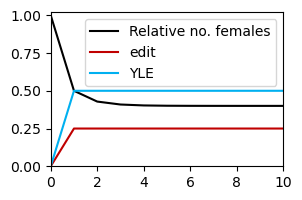

In [142]:
#plot
f1 = PyPlot.figure(figsize=(3,2))
PyPlot.plot(0:t,out["relative_number_females"].adult,c="black","-",label="Relative no. females")
PyPlot.plot(0:t,out["allelefreq_zygote"].a,c="#c00000",label="edit")
PyPlot.plot(0:t,out["yfreq_zygote"].y,c="#00b0f0","-",label="YLE")
PyPlot.ylim(0,1.02)
PyPlot.xlim(0,t)
PyPlot.legend(bbox_to_anchor=(1.0, 1.0,))

PyPlot.show()


## Figure 1

In [143]:
#SIT
pdict = Dict()

pdict[saf]=1.0
pdict[haf]=1.0
pdict[sαf]=1.0
pdict[hαf]=1.0
pdict[saαf]=1.0

pdict[sam]=1.0
pdict[ham]=1.0
pdict[sαm]=1.0
pdict[hαm]=1.0
pdict[saαm]=1.0

pdict[c]=0.0
pdict[j]=0.0
pdict[p]=0.0
pdict[u]=0.0
pdict[q]=0.0

pdict[sy]=0.0

SIT_subs_pdict = pdict
SIT_subs_list = [(p,pdict[p]) for p in keys(pdict)];


#Define release scenario
t=15
release_freq = 1.0
release_genotype=["a" "a" "Y"]
fitness_effect = "b"

#Simulate
SIT_out = Simulate_single_release_example(SIT_subs_list,t,release_freq,release_genotype,fitness_effect=fitness_effect);


In [144]:
#fs-RIDL

pdict = Dict()

pdict[saf]=1.0
pdict[haf]=1.0
pdict[sαf]=1.0
pdict[hαf]=1.0
pdict[saαf]=1.0

pdict[sam]=0.0
pdict[ham]=0.0
pdict[sαm]=0.0
pdict[hαm]=0.0
pdict[saαm]=0.0

pdict[c]=0.0
pdict[j]=0.0
pdict[p]=0.0
pdict[u]=0.0
pdict[q]=0.0

pdict[sy]=0.0

fsRIDL_subs_pdict = pdict
fsRIDL_subs_list = [(p,pdict[p]) for p in keys(pdict)];

#Define release scenario
t=15
release_freq = 1.0
release_genotype=["a" "a" "Y"]
fitness_effect = "a"

#Simulate
fsRIDL_out = Simulate_single_release_example(fsRIDL_subs_list,t,release_freq,release_genotype,fitness_effect=fitness_effect);


In [145]:
#YLE

pdict = Dict()

pdict[saf]=1.0
pdict[haf]=1.0
pdict[sαf]=1.0
pdict[hαf]=1.0
pdict[saαf]=1.0

pdict[sam]=0.0
pdict[ham]=0.0
pdict[sαm]=0.0
pdict[hαm]=0.0
pdict[saαm]=0.0

pdict[c]=1.0
pdict[j]=0.0
pdict[p]=0.0
pdict[u]=1.0
pdict[q]=0.0

pdict[sy]=0.0

YLE_subs_pdict = pdict
YLE_subs_list = [(p,pdict[p]) for p in keys(pdict)];

#Define release scenario
t=15
release_freq = 1.0
release_genotype=["a" "a" "y"]
fitness_effect = "a"


#Simulate
YLE_out = Simulate_single_release_example(YLE_subs_list,t,release_freq,release_genotype,fitness_effect=fitness_effect);


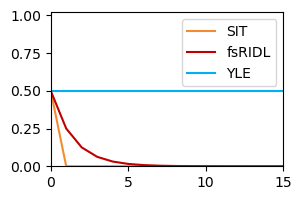

In [146]:
#Plot allele frequencies
f1 = PyPlot.figure(figsize=(3,2))
PyPlot.plot(0:t,SIT_out["allelefreq_reproadult_male"].a,c="#f58b2f","-",label="SIT")
PyPlot.plot(0:t,fsRIDL_out["allelefreq_reproadult_male"].a,c="#c00000","-",label="fsRIDL")
PyPlot.plot(0:t,YLE_out["yfreq_reproadult"].y,c="#00b0f0","-",label="YLE")

PyPlot.ylim(0,1.02)
PyPlot.xlim(0,t)
PyPlot.legend(bbox_to_anchor=(1.0, 1.0,))

PyPlot.show()


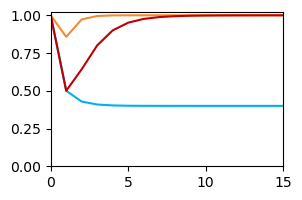

In [147]:
#Plot relative no. females
f1 = PyPlot.figure(figsize=(3,2))
PyPlot.plot(0:t,YLE_out["relative_number_females"].adult,c="#00b0f0","-",label="YLE")
PyPlot.plot(0:t,SIT_out["relative_number_females"].adult,c="#f58b2f","-",label="SIT")
PyPlot.plot(0:t,fsRIDL_out["relative_number_females"].adult,c="#c00000","-",label="fsRIDL")

PyPlot.ylim(0,1.02)
PyPlot.xlim(0,t)

PyPlot.show()


## Figure 5 - Sensitivity analysis using experimental data as baseline

In [82]:
n_releases = 36
t=n_releases
#Set a range of intrinsic rates of increase
Rm_vec = [2,6,12];
thresholds = [0.05,0.01]

2-element Vector{Float64}:
 0.05
 0.01

In [83]:
#Perform the sensitivity analysis for a goal of 95% suppression
threshold = 0.05

#Define colours for plot lines at different Rms
cols = ["#f3bf02","#f58b2f","#ff5177"]
set=1

1

#### Calculation of parameters from experimental data

In [84]:
# Converting the proportion of offspring carrying the construct to cleavage and joining rates 
D, E, U = symbols("d e u");

#d = transmission rate - proportion of offspring carrying construct from a het x WT cross
#e = probability of cleavage and homing. e = 2(d-0.5)
#u = proportion of non-homed alleles which are R

non_homed = 1-E #probability of not homing
WT = non_homed*(1-U) #probability of being WT
NHEJ = non_homed*U #probability of being NHEJ

# c = probability of cleavage = homing + NHEJ
C = E+NHEJ

# j = probability of joining given cleavage
J= simplify(NHEJ/C)

#Experimental data
d_ = [0.945]
e_ = (d_.-0.5).*2

#Proportion of all alleles which are neither WT nor the released mutation
Altmut = 0.02
#Proportion of all non-homed alleles which are NHEJ products
u_ = Altmut./(1 .-d_)

c_ = [subs(C,(E,e_[i]),(U,u_[i])) for i in 1:length(e_)]
j_ = [subs(J,(E,e_[i]),(U,u_[i])) for i in 1:length(e_)]

1-element Vector{Sym{PyCall.PyObject}}:
 0.0430107526881721

In [85]:
c_

1-element Vector{Sym{PyCall.PyObject}}:
 0.930000000000000

In [86]:
j_

1-element Vector{Sym{PyCall.PyObject}}:
 0.0430107526881721

#### Calculation of release rate required for experimental case

In [87]:
#Release rates at baseline for 99% and 
YLEdsx_rr_rm = Array{Float64}(undef,2,3)
y=0
for Rm in [2,6,12]
    y=y+1
    x=0
    for threshold in thresholds
        x=x+1
        rr = find_release_rate_required(
                        n_releases,
                        0.0,
                        threshold,
                        YLE_subs_pdict;
                        t=n_releases,
                        release_genotype=["A" "a" "y"],
                        fitness_effect = "a",
                        param_label=[c,j,p,q,hαf,sy],
                        param_mod=[c_[1],j_[1],0.0,0.0,0.0,0.21],
                        Rm=Rm)
        
        YLEdsx_rr_rm[x,y]=rr
    end
end

YLEdsx_rr_rm

2×3 Matrix{Float64}:
 0.0623  0.178   0.4149
 0.064   0.1887  0.4704

#### Cleavage in hets 

In [88]:
#Cleavage in hets 
param_mod_list = collect(0.0:0.01:1.0)
param_label=[hαf,c,j,sy]
rr_output = Array{Float64}(undef,length(param_mod_list),length(Rm_vec))

y = 0
for Rm in Rm_vec
    y = y+1
    x = 0
    for param_mod in param_mod_list
        x = x + 1
        rr = find_release_rate_required(
            n_releases,
            0.0,
            threshold,
            YLE_subs_pdict;
            t=n_releases,
            release_genotype=["A" "a" "y"],
            fitness_effect = "a",
            param_mod=[0.0,param_mod,j_[set],0.22],
            param_label=param_label,
            Rm = Rm)

        rr_output[x,y] = rr
    end
end


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


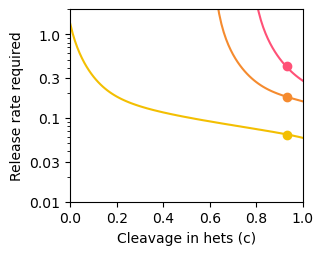

In [89]:
#plot
f1 = PyPlot.figure(figsize=(3,2.5))
for i in 1:3
    PyPlot.plot(param_mod_list,rr_output[:,i],cols[i])
    PyPlot.plot(Float64(c_[set]),YLEdsx_rr_rm[1,i],"o",color = cols[i])
end

PyPlot.xlim(0,maximum(param_mod_list))
PyPlot.yscale("log")
PyPlot.ylim(0.018,2)
PyPlot.yticks([0.01,0.03,0.1,0.3,1],[0.01,0.03,0.1,0.3,1])

PyPlot.ylabel("Release rate required")
PyPlot.xlabel("Cleavage in hets (c)")
 
PyPlot.show()
PyPlot.savefig("../figures/SensitivityAnalysis_c_withcost.pdf",bbox_inches = "tight")

#### NHEJ in hets 

In [90]:
#NHEJ in hets
param_mod_list = collect(0.0:0.01:1.0)
param_label = [hαf,c,j,sy]
rr_output = Array{Float64}(undef,length(param_mod_list),length(Rm_vec))

y = 0
for Rm in Rm_vec
    y = y+1
    x = 0
    for param_mod in param_mod_list
        x = x + 1
        rr = find_release_rate_required(
            n_releases,
            0.0,
            threshold,
            YLE_subs_pdict;
            t=n_releases,
            release_genotype=["A" "a" "y"],
            fitness_effect = "a",
            param_mod=[0.0,c_[set],param_mod,0.22],
            param_label=param_label,
            Rm = Rm)

        rr_output[x,y] = rr
    end
end


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


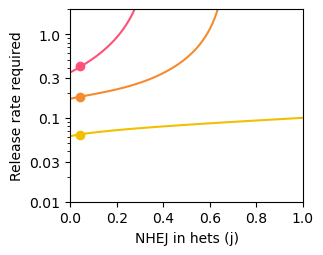

In [91]:
#plot
f1 = PyPlot.figure(figsize=(3,2.5))
for i in 1:3
    PyPlot.plot(param_mod_list,rr_output[:,i],cols[i])
    PyPlot.plot(Float64(j_[set]),YLEdsx_rr_rm[1,i],"o",color = cols[i])
end

PyPlot.xlim(0,maximum(param_mod_list))
PyPlot.yscale("log")
PyPlot.ylim(0.018,2)
PyPlot.yticks([0.01,0.03,0.1,0.3,1],[0.01,0.03,0.1,0.3,1])

PyPlot.ylabel("Release rate required")
PyPlot.xlabel("NHEJ in hets (j)")
 
PyPlot.show()
PyPlot.savefig("../figures/SensitivityAnalysis_j_withcost.pdf",bbox_inches = "tight")

#### Mutation rate in WT

In [92]:
#NHEJ in hets
param_mod_list = collect(0:0.01:1.0)
param_label = [hαf,c,j,u,sy]
rr_output = Array{Float64}(undef,length(param_mod_list),length(Rm_vec))

y = 0
for Rm in Rm_vec
    y = y+1
    x = 0
    for param_mod in param_mod_list
        x = x + 1
        rr = find_release_rate_required(
            n_releases,
            0.0,
            threshold,
            YLE_subs_pdict;
            t=n_releases,
            release_genotype=["A" "a" "y"],
            fitness_effect = "a",
            param_mod=[0.0,c_[set],j_[set],param_mod,0.22],
            param_label=param_label,
            Rm = Rm)

        rr_output[x,y] = rr
    end
end

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


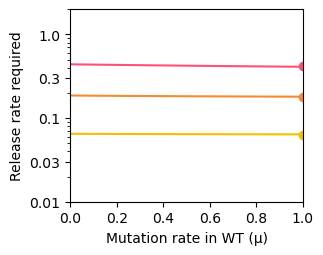

In [93]:
#plot
f1 = PyPlot.figure(figsize=(3,2.5))
for i in 1:3
    PyPlot.plot(param_mod_list,rr_output[:,i],cols[i])
    PyPlot.plot(Float64(1.0),YLEdsx_rr_rm[1,i],"o",color = cols[i])
end

PyPlot.xlim(0,maximum(param_mod_list))
PyPlot.yscale("log")
PyPlot.ylim(0.018,2)
PyPlot.yticks([0.01,0.03,0.1,0.3,1],[0.01,0.03,0.1,0.3,1])

PyPlot.ylabel("Release rate required")
PyPlot.xlabel("Mutation rate in WT (μ)")
 
PyPlot.show()
PyPlot.savefig("../figures/SensitivityAnalysis_u_withcost.pdf",bbox_inches = "tight")

#### Dominance coefficient of mutation

In [94]:
#Dominance coefficient of mutation
param_mod_list = collect(0:0.01:1.0)
param_label = [hαf,c,j,haf,sy]
rr_output = Array{Float64}(undef,length(param_mod_list),length(Rm_vec))

y = 0
for Rm in Rm_vec
    y = y+1
    x = 0
    for param_mod in param_mod_list
        x = x + 1
        rr = find_release_rate_required(
            n_releases,
            0.0,
            threshold,
            YLE_subs_pdict;
            t=n_releases,
            release_genotype=["A" "a" "y"],
            fitness_effect = "a",
            param_mod=[0.0,c_[set],j_[set],param_mod,0.22],
            param_label=param_label,
            Rm = Rm)

        rr_output[x,y] = rr
    end
end


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


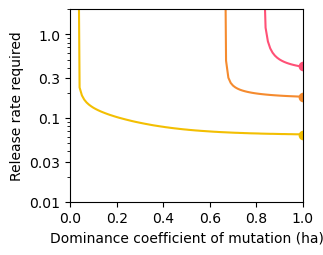

In [95]:
#plot
f1 = PyPlot.figure(figsize=(3,2.5))
for i in 1:3
    PyPlot.plot(param_mod_list,rr_output[:,i],cols[i])
    PyPlot.plot(1.0,YLEdsx_rr_rm[1,i],"o",color = cols[i])
end

PyPlot.xlim(0,maximum(param_mod_list))
PyPlot.yscale("log")
PyPlot.ylim(0.018,2)
PyPlot.yticks([0.01,0.03,0.1,0.3,1],[0.01,0.03,0.1,0.3,1])

PyPlot.ylabel("Release rate required")
PyPlot.xlabel("Dominance coefficient of mutation (ha)")
 
PyPlot.show()
PyPlot.savefig("../figures/SensitivityAnalysis_ha_withcost.pdf",bbox_inches = "tight")

#### Dominance coefficientof NHEJ

In [96]:
#Dominance coefficient of NHEJ
param_mod_list = collect(0:0.01:1.0)
param_label = [hαf,c,j,sy]
rr_output = Array{Float64}(undef,length(param_mod_list),length(Rm_vec))

y = 0
for Rm in Rm_vec
    y = y+1
    x = 0
    for param_mod in param_mod_list
        x = x + 1
        rr = find_release_rate_required(
            n_releases,
            0.0,
            threshold,
            YLE_subs_pdict;
            t=n_releases,
            release_genotype=["A" "a" "y"],
            fitness_effect = "a",
            param_mod=[param_mod,c_[set],j_[set],0.22],
            param_label=param_label,
            Rm = Rm)

        rr_output[x,y] = rr
    end
end


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


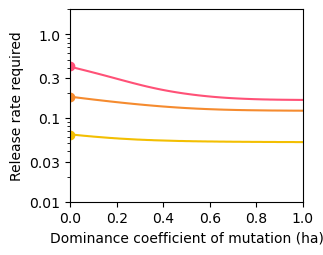

In [97]:
#plot
f1 = PyPlot.figure(figsize=(3,2.5))
for i in 1:3
    PyPlot.plot(param_mod_list,rr_output[:,i],cols[i])
    PyPlot.plot(0.0,YLEdsx_rr_rm[1,i],"o",color = cols[i])
end

PyPlot.xlim(0,maximum(param_mod_list))
PyPlot.yscale("log")
PyPlot.ylim(0.018,2)
PyPlot.yticks([0.01,0.03,0.1,0.3,1],[0.01,0.03,0.1,0.3,1])

PyPlot.ylabel("Release rate required")
PyPlot.xlabel("Dominance coefficient of mutation (ha)")
 
PyPlot.show()
PyPlot.savefig("../figures/SensitivityAnalysis_halpha_withcost.pdf",bbox_inches = "tight")

#### Proportion of NHEJ which are dominant

In [98]:
#Proportion of NHEJ which are dominant
param_mod_list = collect(0:0.01:1.0)
param_label = [hαf,c,j,p,q,sy]
rr_output = Array{Float64}(undef,length(param_mod_list),length(Rm_vec))

y = 0
for Rm in Rm_vec
    y = y+1
    x = 0
    for param_mod in param_mod_list
        x = x + 1
        rr = find_release_rate_required(
            n_releases,
            0.0,
            threshold,
            YLE_subs_pdict;
            t=n_releases,
            release_genotype=["A" "a" "y"],
            fitness_effect = "a",
            param_mod=[0.0,c_[set],j_[set],param_mod,param_mod,0.22],
            param_label=param_label,
            Rm = Rm)

        rr_output[x,y] = rr
    end
end


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


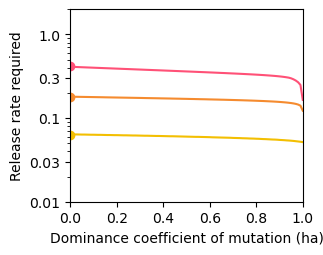

In [99]:
#plot
f1 = PyPlot.figure(figsize=(3,2.5))
for i in 1:3
    PyPlot.plot(param_mod_list,rr_output[:,i],cols[i])
    PyPlot.plot(0.0,YLEdsx_rr_rm[1,i],"o",color = cols[i])
end

PyPlot.xlim(0,maximum(param_mod_list))
PyPlot.yscale("log")
PyPlot.ylim(0.018,2)
PyPlot.yticks([0.01,0.03,0.1,0.3,1],[0.01,0.03,0.1,0.3,1])

PyPlot.ylabel("Release rate required")
PyPlot.xlabel("Dominance coefficient of mutation (ha)")
 
PyPlot.show()
PyPlot.savefig("../figures/SensitivityAnalysis_pq_withcost.pdf",bbox_inches = "tight")

#### Costs of YLE in males

In [100]:
#Proportion of NHEJ which are dominant
param_mod_list = collect(0:0.01:1.0)
param_label = [hαf,c,j,sy]
rr_output = Array{Float64}(undef,length(param_mod_list),length(Rm_vec))

y = 0
for Rm in Rm_vec
    y = y+1
    x = 0
    for param_mod in param_mod_list
        x = x + 1
        rr = find_release_rate_required(
            n_releases,
            0.0,
            threshold,
            YLE_subs_pdict;
            t=n_releases,
            release_genotype=["A" "a" "y"],
            fitness_effect = "a",
            param_mod=[0.0,c_[set],j_[set],param_mod],
            param_label=param_label,
            Rm = Rm)

        rr_output[x,y] = rr
    end
end


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


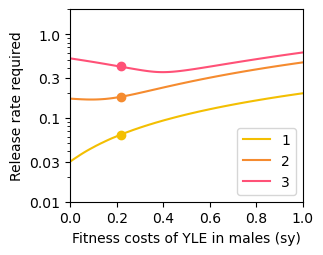

In [101]:
#plot
f1 = PyPlot.figure(figsize=(3,2.5))
for i in 1:3
    PyPlot.plot(param_mod_list,rr_output[:,i],cols[i],label=i)
    PyPlot.plot(0.22,YLEdsx_rr_rm[1,i],"o",color = cols[i])
end

PyPlot.xlim(0,maximum(param_mod_list))
PyPlot.yscale("log")
PyPlot.ylim(0.018,2)
PyPlot.yticks([0.01,0.03,0.1,0.3,1],[0.01,0.03,0.1,0.3,1])

PyPlot.ylabel("Release rate required")
PyPlot.xlabel("Fitness costs of YLE in males (sy)")
 
PyPlot.show()
PyPlot.legend()
PyPlot.savefig("../figures/SensitivityAnalysis_sy.pdf",bbox_inches = "tight")

## Figure 6 - Time course

In [102]:
#Define parametr values for simulations based on experimental data
YLEdsx_subs_pdict = deepcopy(YLE_subs_pdict)
YLEdsx_subs_pdict[c] = c_[1] 
YLEdsx_subs_pdict[j] = j_[1] 
YLEdsx_subs_pdict[hαf] = 0.0
YLEdsx_subs_pdict[sy] = 0.22
YLEdsx_subs_list = [(p,YLEdsx_subs_pdict[p]) for p in keys(pdict)];

### Single release 100%

In [103]:
#Single release 100%
t=40
release_freq = 1.0
release_genotype=["A" "a" "y"]
fitness_effect = "a"
release_regime = false

YLESingle_out = Simulate_single_release_example(YLEdsx_subs_list,t,release_freq,release_genotype,release_regime = false,fitness_effect = "a");

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


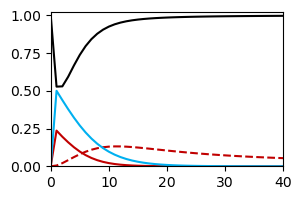

In [104]:
f1 = PyPlot.figure(figsize=(3,2))

PyPlot.plot(0:t,YLESingle_out["relative_number_females"].adult,c="black","-")
PyPlot.plot(0:t,YLESingle_out["allelefreq_zygote"].a,c="#c00000","-")
PyPlot.plot(0:t,YLESingle_out["allelefreq_zygote"].α,c="#c00000","--")
PyPlot.plot(0:t,YLESingle_out["yfreq_zygote"].y,c="#00b0f0","-")

PyPlot.ylim(0,1.02)
PyPlot.xlim(0,t)

PyPlot.show()
PyPlot.savefig("../figures/TimeSeries_100SingleRelease_withcost.pdf",bbox_inches = "tight")

### Repeat release 20% for 6 generations

In [105]:
#Repeat release 20% for 6 generations

t=40
release_freq = 0.2
release_genotype=["A" "a" "y"]
fitness_effect = "a"
n_releases = 6
release_regime = repeat([0.0],t)
for i in 1:n_releases
    release_regime[i] = release_freq
end

YLE6Rep_out = Simulate_single_release_example(YLEdsx_subs_list,t,release_freq,release_genotype,release_regime = release_regime,fitness_effect = "a");


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


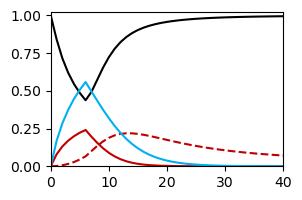

In [106]:
f1 = PyPlot.figure(figsize=(3,2))

PyPlot.plot(0:t,YLE6Rep_out["relative_number_females"].adult,c="black","-")
PyPlot.plot(0:t,YLE6Rep_out["allelefreq_zygote"].a,c="#c00000","-")
PyPlot.plot(0:t,YLE6Rep_out["allelefreq_zygote"].α,c="#c00000","--")
PyPlot.plot(0:t,YLE6Rep_out["yfreq_zygote"].y,c="#00b0f0","-")

PyPlot.ylim(0,1.02)
PyPlot.xlim(0,t)

PyPlot.show()
PyPlot.savefig("../figures/TimeSeries_20Rep6Release_withcost.pdf",bbox_inches = "tight")

### Repeat release 20% every generation

In [107]:
#Repeat release 20% every generation

t=40
release_freq = 0.2
release_genotype=["A" "a" "y"]
fitness_effect = "a"
n_releases = t
release_regime = repeat([0.0],t)
for i in 1:n_releases
    release_regime[i] = release_freq
end

YLERep_out = Simulate_single_release_example(YLEdsx_subs_list,t,release_freq,release_genotype,release_regime = release_regime,fitness_effect = "a");

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


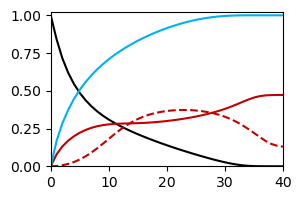

In [108]:
f1 = PyPlot.figure(figsize=(3,2))

PyPlot.plot(0:t,YLERep_out["relative_number_females"].adult,c="black","-")
PyPlot.plot(0:t,YLERep_out["allelefreq_zygote"].a,c="#c00000","-")
PyPlot.plot(0:t,YLERep_out["allelefreq_zygote"].α,c="#c00000","--")
PyPlot.plot(0:t,YLERep_out["yfreq_zygote"].y,c="#00b0f0","-")

PyPlot.ylim(0,1.02)
PyPlot.xlim(0,t)

PyPlot.show()
PyPlot.savefig("../figures/TimeSeries_20RepRelease_withcost.pdf",bbox_inches = "tight")

## Table 1

### Finding the release rates for different single locus strategie

In [148]:
#Define the number of releases in which the desired level of suppression is needed
n_releases = 36
t=36
#Define the level of suppression
thresholds = [0.33,0.05,0.01]

3-element Vector{Float64}:
 0.33
 0.05
 0.01

In [150]:
#Empirical YLE
YLEdsx_rr = []
for threshold in thresholds
    rr = find_release_rate_required(
                    n_releases,
                    0.0,
                    threshold,
                    YLE_subs_pdict;
                    t=n_releases,
                    release_genotype=["A" "a" "y"],
                    fitness_effect = "a",
                    param_label=[c,j,p,q,hαf,sy],
                    param_mod=[c_[1],j_[1],0.0,0.0,0.0,0.22])
    push!(YLEdsx_rr,rr)
end
YLEdsx_rr

3-element Vector{Any}:
 0.1341
 0.18010000000000004
 0.1904

In [111]:
#Optimal YLE
YLE_rr = []
for threshold in thresholds
    rr = find_release_rate_required(
                    n_releases,
                    0.0,
                    threshold,
                    YLE_subs_pdict;
                    t=n_releases,
                    release_genotype=["a" "a" "y"],
                    fitness_effect = "a")
    push!(YLE_rr,rr)
end
YLE_rr

3-element Vector{Any}:
 0.021099999999999997
 0.03650000000000002
 0.040800000000000024

In [112]:
YLE_rr./YLEdsx_rr

3-element Vector{Float64}:
 0.15734526472781504
 0.20266518600777353
 0.21428571428571438

In [113]:
#OPtimal SIT
SIT_rr = []
for threshold in thresholds
    rr = find_release_rate_required(
                    n_releases,
                    0.0,
                    threshold,
                    SIT_subs_pdict;
                    t=n_releases,
                    release_genotype=["a" "a" "Y"],
                    fitness_effect = "b")
    push!(SIT_rr,rr)
end
SIT_rr

3-element Vector{Any}:
 1.2851999999999997
 1.2969999999999995
 1.2995999999999992

In [114]:
SIT_rr./YLEdsx_rr

3-element Vector{Float64}:
 9.583892617449662
 7.201554691837863
 6.825630252100836

In [115]:
#Optimal fsRIDL
fsRIDL_rr = []
for threshold in thresholds
    rr = find_release_rate_required(
                    n_releases,
                    0.0,
                    threshold,
                    fsRIDL_subs_pdict;
                    t=n_releases,
                    release_genotype=["a" "a" "Y"],
                    fitness_effect = "a")
    push!(fsRIDL_rr,rr)
end
fsRIDL_rr

3-element Vector{Any}:
 0.47230000000000005
 0.6674
 0.6774

In [116]:
fsRIDL_rr./YLEdsx_rr

3-element Vector{Float64}:
 3.5219985085756904
 3.7057190449750133
 3.5577731092436973

In [117]:
#OPtimal RIDL
RIDL_rr = []
for threshold in thresholds
    rr = find_release_rate_required(
                    n_releases,
                    0.0,
                    threshold,
                    fsRIDL_subs_pdict;
                    t=n_releases,
                    release_genotype=["a" "a" "y"],
                    fitness_effect = "a",
                    param_label=[sam,ham,sαm,hαm,saαm],
                    param_mod=[1.0,1.0,1.0,1.0,1.0])
    push!(RIDL_rr,rr)
end
RIDL_rr

3-element Vector{Any}:
 0.4185
 0.4376
 0.43920000000000003

In [118]:
RIDL_rr./YLEdsx_rr

3-element Vector{Float64}:
 3.120805369127517
 2.42976124375347
 2.30672268907563

### Finding the release rates for stratgies involving X-shredding (load in 2-locus model)

Note that 3 alleles are encoded for the X-shredder containing locus, however for this project only 2 are used. 

#### Define variables

In [119]:
#Define all alleles, genotypes, inheritance and fitness data structures

A_alleles = ['A','a','α']
#A = WT
#a = X-shredder
#α = edit

B_alleles = ['B','b','β'];
#B = target site
#b = edit 1
#β = edit 2

Y_genotypes = ["Y","y"];
#Y = WT
#y = construct


#Define all A and B allele combinations: Creating single chromosomes due to linkage
#in females
alleles = []
for A in A_alleles
    for B in B_alleles
        push!(alleles,(A*B))
    end
end;
falleles = alleles
#in males
alleles_m = []
for A in A_alleles
    for B in B_alleles
        for Y in Y_genotypes
            push!(alleles_m,(A*B, Y))
        end
    end
end;
malleles = alleles_m
        
#Define all genotypes at locus A
A_genotypes = []
for i in 1:length(A_alleles)
    allele1 = A_alleles[i]
    for j in i:length(A_alleles)
        allele2 = A_alleles[j]
        push!(A_genotypes,(allele1*allele2))
    end
end;
       
#Define all genotypes at locus B
B_genotypes = []
for i in 1:length(B_alleles)
    allele1 = B_alleles[i]
    for j in i:length(B_alleles)
        allele2 = B_alleles[j]
        push!(B_genotypes,(allele1*allele2))
    end
end;
                
#Define all genotypes for both A and B loci combined
#in females
genotypes_f = []
for i in 1:length(alleles)
    allele1 = alleles[i]
    for j in i:length(alleles)
        allele2 = alleles[j]
        push!(genotypes_f,([allele1 allele2]))
    end
end;
                    
#in males
genotypes_m = []
for i in genotypes_f
    allele1 = i[1]
    allele2 = i[2]
    for yallele in Y_genotypes
        push!(genotypes_m,([allele1 allele2 yallele]))
    end
end
                        
#Load in model
sbf, hbf, sβf, hβf, sbβf,sbm, hbm, sβm, hβm, sbβm, sXam, c, j, p, u, q, m = Sym("sbf hbf sβf hβf sbβf sbm hbm sβm hβm sbβm sXam c j p u q m")

#Read in genotypes from storage
genotypes_f_string = readdlm("./YLEXS/YLEXS_genotypes_f.csv", ',', String,header=false);
genotypes_m_string = readdlm("./YLEXS/YLEXS_genotypes_m.csv", ',', String,header=false);

#Define dictionary for indexing 
index_dict_f = Dict()
[index_dict_f[genotypes_f_string[i]] = i for i in 1:length(genotypes_f_string)]
index_dict_f

index_dict_m = Dict()
[index_dict_m[genotypes_m_string[i]] = i for i in 1:length(genotypes_m_string)]
index_dict_m

#Read in and convert data back to IC_F
flattened_ic_f = readdlm("./YLEXS/YLEXS_inheritance_f.csv", ',', String,header=true)[1]
flattened_ic_f = convert(Array{Any}, flattened_ic_f)
flattened_ic_f[:,1] = [index_dict_f[i] for i in flattened_ic_f[:,1]]
flattened_ic_f[:,2] = [index_dict_m[i] for i in flattened_ic_f[:,2]]
flattened_ic_f[:,3:end] = eval.(Meta.parse.(flattened_ic_f[:,3:end]))
ic_f = Array{Any}(undef,length(genotypes_f_string),length(genotypes_m_string),length(genotypes_f_string))
for i in 1:length(flattened_ic_f[:,1])
    mother,father = flattened_ic_f[i,1:2]
    ic_f[mother,father,:] = flattened_ic_f[i,3:end]
end
ic_f = Sym.(ic_f);

#Read in and convert data back to IC_M
flattened_ic_m = readdlm("./YLEXS/YLEXS_inheritance_m.csv", ',', String,header=true)[1]
flattened_ic_m = convert(Array{Any}, flattened_ic_m)
flattened_ic_m[:,1] = [index_dict_f[i] for i in flattened_ic_m[:,1]]
flattened_ic_m[:,2] = [index_dict_m[i] for i in flattened_ic_m[:,2]]
flattened_ic_m[:,3:end] = eval.(Meta.parse.(flattened_ic_m[:,3:end]))
ic_m = Array{Any}(undef,length(genotypes_f_string),length(genotypes_m_string),length(genotypes_m_string))
for i in 1:length(flattened_ic_m[:,1])
    mother,father = flattened_ic_m[i,1:2]
    ic_m[mother,father,:] = flattened_ic_m[i,3:end]
end
ic_m = Sym.(ic_m);

#Read in fitness from storage
fitness_f = readdlm("./YLEXS/YLEXS_fitness_f.csv", ',', String,header=true)[1]
fitness_f = convert(Array{Any}, fitness_f)
fitness_f = eval.(Meta.parse.(fitness_f))
fitness_f = Sym.(fitness_f)

fitness_m = readdlm("./YLEXS/YLEXS_fitness_m.csv", ',', String,header=true)[1]
fitness_m = convert(Array{Any}, fitness_m)
fitness_m = eval.(Meta.parse.(fitness_m))
fitness_m = Sym.(fitness_m);

#### Identify release rate

In [120]:
#OPtimal X-shredder param setup

# Define parameters and save in dictionary (set values as you wish)
pdict = Dict()
pdict[sbf]=1.0
pdict[hbf]=1.0
pdict[sβf]=1.0
pdict[hβf]=1.0
pdict[sbβf]=1.0

pdict[c]=0.0
pdict[j]=0.0

pdict[p]=0.0
pdict[u]=0.0
pdict[q]=0.0
pdict[m] = 1.0
pdict[sXam]=0.0

Rm = 6
Nf_eq = 1000.0
params=Dict()
params["OJ"] = 1/10
params["f"] = (2*Rm)/params["OJ"]
params["α"] = params["f"]*Nf_eq/(Rm-1)
params["fm"]=0.0

# Substitute symbols for numerical values: outputs are sex_ratio, fitness and inheritance
subs_list = [(p,pdict[p]) for p in keys(pdict)];

#Fitness
fitness_f_vals = Array{Float64}(fitness_f.subs(subs_list))
fitness_m_vals = Array{Float64}(fitness_m.subs(subs_list))

#inheritance
Nf = length(ic_f[1,1,:])
Nm = length(ic_m[1,1,:])
ic_vals = Array{Any,3}(nothing,Nf,Nm,Nf)
for i in 1:Nf
    ic_vals[i,:,:] = ic_f[i,:,:].subs(subs_list)
end
ic_f_vals = Array{Float64}(ic_vals);

ic_vals = Array{Any,3}(nothing,Nf,Nm,Nm)
for i in 1:Nf
    ic_vals[i,:,:] = ic_m[i,:,:].subs(subs_list)
end
ic_m_vals = Array{Float64}(ic_vals);


In [121]:
#OPtimal X-shredder
release_genotype=["aB" "aB" "Y"]
threshold = 0.05
XS_rr = []
for threshold in thresholds
    rr = find_release_rate_required_2locus(release_genotype,
                                    threshold,
                                    ic_f_vals,
                                    ic_m_vals,
                                    fitness_f_vals,
                                    fitness_m_vals,
                                    params,
                                    fitness_effect="a")
    push!(XS_rr,rr)
end
XS_rr

3-element Vector{Any}:
 0.23920000000000005
 0.3955000000000001
 0.4021

In [122]:
XS_rr./YLEdsx_rr

3-element Vector{Float64}:
 1.7837434750186432
 2.1960022209883396
 2.1118697478991595

In [123]:
#Experimental YLE+XS setup [With REC NHEJ]

# Define parameters and save in dictionary (set values as you wish)
pdict = Dict()
pdict[sbf]=1.0
pdict[hbf]=1.0
pdict[sβf]=1.0
pdict[hβf]=0.0 #recessive NHEJ mutations
pdict[sbβf]=1.0

pdict[c]=c_[1] #Experimental value
pdict[j]=j_[1] #Experimental value

pdict[sy]=0.22 #From cage data inference

pdict[p]=0.0
pdict[u]=1.0
pdict[q]=0.0
pdict[m] = 0.9 #Experimental value
pdict[sXam]=0.2 #Experimental value

Rm = 6
Nf_eq = 1000.0
params=Dict()
params["OJ"] = 1/10
params["f"] = (2*Rm)/params["OJ"]
params["α"] = params["f"]*Nf_eq/(Rm-1)
params["fm"]=pdict[sXam] #Experimental value

# Substitute symbols for numerical values: outputs are sex_ratio, fitness and inheritance
subs_list = [(p,pdict[p]) for p in keys(pdict)];

#Fitness
fitness_f_vals = Array{Float64}(fitness_f.subs(subs_list))
fitness_m_vals = Array{Float64}(fitness_m.subs(subs_list))

#inheritance
Nf = length(ic_f[1,1,:])
Nm = length(ic_m[1,1,:])
ic_vals = Array{Any,3}(nothing,Nf,Nm,Nf)
for i in 1:Nf
    ic_vals[i,:,:] = ic_f[i,:,:].subs(subs_list)
end
ic_f_vals = Array{Float64}(ic_vals);

ic_vals = Array{Any,3}(nothing,Nf,Nm,Nm)
for i in 1:Nf
    ic_vals[i,:,:] = ic_m[i,:,:].subs(subs_list)
end
ic_m_vals = Array{Float64}(ic_vals);

In [124]:
release_genotype=["Ab" "aB" "y"]
hetYLEXS_rr = []
for threshold in thresholds
    rr = find_release_rate_required_2locus(release_genotype,
                                    threshold,
                                    ic_f_vals,
                                    ic_m_vals,
                                    fitness_f_vals,
                                    fitness_m_vals,
                                    params,
                                    fitness_effect="s")
    push!(hetYLEXS_rr,rr)
end
hetYLEXS_rr

3-element Vector{Any}:
 0.03430000000000001
 0.11380000000000003
 0.12200000000000004

In [125]:
hetYLEXS_rr./YLEdsx_rr

3-element Vector{Float64}:
 0.2557792692020881
 0.6318711826762909
 0.6407563025210086

In [126]:
release_genotype=["aB" "ab" "y"]
homYLEXS_rr = []
for threshold in thresholds
    rr = find_release_rate_required_2locus(release_genotype,
                                    threshold,
                                    ic_f_vals,
                                    ic_m_vals,
                                    fitness_f_vals,
                                    fitness_m_vals,
                                    params,
                                    fitness_effect="s")
    push!(homYLEXS_rr,rr)
end
homYLEXS_rr

3-element Vector{Any}:
 0.0263
 0.08830000000000002
 0.09450000000000001

In [127]:
homYLEXS_rr./YLEdsx_rr

3-element Vector{Float64}:
 0.19612229679343773
 0.49028317601332594
 0.4963235294117647

In [128]:
#Experimental YLE+XS setup [With Dom NHEJ]

# Define parameters and save in dictionary (set values as you wish)
pdict = Dict()
pdict[sbf]=1.0
pdict[hbf]=1.0
pdict[sβf]=1.0
pdict[hβf]=1.0 #recessive NHEJ mutations
pdict[sbβf]=1.0

pdict[c]=c_[1] #Experimental value
pdict[j]=j_[1] #Experimental value
pdict[sy]=0.22

pdict[p]=0.0
pdict[u]=1.0
pdict[q]=0.0
pdict[m] = 0.9 #Experimental value
pdict[sXam]=0.2 #Experimental value

Rm = 6
Nf_eq = 1000.0
#params = Initiate_baseline_parameters()
params=Dict()
params["OJ"] = 1/10
params["f"] = (2*Rm)/params["OJ"]
params["α"] = params["f"]*Nf_eq/(Rm-1)
params["fm"]=pdict[sXam] #Experimental value

# Substitute symbols for numerical values: outputs are sex_ratio, fitness and inheritance
subs_list = [(p,pdict[p]) for p in keys(pdict)];

#Fitness
fitness_f_vals = Array{Float64}(fitness_f.subs(subs_list))
fitness_m_vals = Array{Float64}(fitness_m.subs(subs_list))

#inheritance
Nf = length(ic_f[1,1,:])
Nm = length(ic_m[1,1,:])
ic_vals = Array{Any,3}(nothing,Nf,Nm,Nf)
for i in 1:Nf
    ic_vals[i,:,:] = ic_f[i,:,:].subs(subs_list)
end
ic_f_vals = Array{Float64}(ic_vals);

ic_vals = Array{Any,3}(nothing,Nf,Nm,Nm)
for i in 1:Nf
    ic_vals[i,:,:] = ic_m[i,:,:].subs(subs_list)
end
ic_m_vals = Array{Float64}(ic_vals);

In [129]:
release_genotype=["Ab" "aB" "y"]
hetYLEXS_rr = []
for threshold in thresholds
    rr = find_release_rate_required_2locus(release_genotype,
                                    threshold,
                                    ic_f_vals,
                                    ic_m_vals,
                                    fitness_f_vals,
                                    fitness_m_vals,
                                    params,
                                    fitness_effect="s")
    push!(hetYLEXS_rr,rr)
end
hetYLEXS_rr

3-element Vector{Any}:
 0.009899999999999996
 0.0189
 0.021999999999999992

In [130]:
release_genotype=["aB" "ab" "y"]
homYLEXS_rr = []
for threshold in thresholds
    rr = find_release_rate_required_2locus(release_genotype,
                                    threshold,
                                    ic_f_vals,
                                    ic_m_vals,
                                    fitness_f_vals,
                                    fitness_m_vals,
                                    params,
                                    fitness_effect="s")
    push!(homYLEXS_rr,rr)
end
homYLEXS_rr

3-element Vector{Any}:
 0.007200000000000001
 0.014100000000000001
 0.0166